[EDA](https://www.kaggle.com/maximmezhov/cardiospike-eda)  
[Подготовка датасета](https://www.kaggle.com/maximmezhov/cardiospike-feature-development)

In [1]:
import pandas as pd
import pickle
import catboost
import lightgbm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
RANDOM_STATE = 0

In [3]:
with open('../input/cardiospike-feature-development/dataset_v1.pkl', 'rb') as f:
    df = pickle.load(f)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59113 entries, 3 to 60483
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  59113 non-null  int64  
 1   time                59113 non-null  int64  
 2   x                   59113 non-null  int64  
 3   y                   59113 non-null  int64  
 4   x_diff              59113 non-null  float64
 5   x_deviation_median  59113 non-null  float64
 6   x+1                 59113 non-null  float64
 7   x-1                 59113 non-null  float64
 8   x+2                 59113 non-null  float64
 9   x-2                 59113 non-null  float64
 10  x+3                 59113 non-null  float64
 11  x-3                 59113 non-null  float64
 12  x-(x+1)             59113 non-null  float64
 13  x-(x-1)             59113 non-null  float64
 14  x-(x+2)             59113 non-null  float64
 15  x-(x-2)             59113 non-null  float64
 16  x-(x

In [4]:
df.head()

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
3,1,2392,820,0,28.0,-72.0,804.0,792.0,828.0,780.0,916.0,800.0,16.0,28.0,-8.0,40.0,-96.0,20.0
4,1,3196,804,0,-16.0,-56.0,828.0,820.0,916.0,792.0,960.0,780.0,-24.0,-16.0,-112.0,12.0,-156.0,24.0
5,1,4024,828,0,24.0,-80.0,916.0,804.0,960.0,820.0,956.0,792.0,-88.0,24.0,-132.0,8.0,-128.0,36.0
6,1,4940,916,0,88.0,-168.0,960.0,828.0,956.0,804.0,928.0,820.0,-44.0,88.0,-40.0,112.0,-12.0,96.0
7,1,5900,960,0,44.0,-212.0,956.0,916.0,928.0,828.0,836.0,804.0,4.0,44.0,32.0,132.0,124.0,156.0


# X, y

In [5]:
X = df.drop(['y','id','time'], axis=1)
y = df.y.to_numpy()

display(X.head())

scaler = StandardScaler().fit(X.to_numpy())
X = scaler.transform(X.to_numpy())

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
print(X.shape, y.shape)

,x,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
3,820,28.0,-72.0,804.0,792.0,828.0,780.0,916.0,800.0,16.0,28.0,-8.0,40.0,-96.0,20.0
4,804,-16.0,-56.0,828.0,820.0,916.0,792.0,960.0,780.0,-24.0,-16.0,-112.0,12.0,-156.0,24.0
5,828,24.0,-80.0,916.0,804.0,960.0,820.0,956.0,792.0,-88.0,24.0,-132.0,8.0,-128.0,36.0
6,916,88.0,-168.0,960.0,828.0,956.0,804.0,928.0,820.0,-44.0,88.0,-40.0,112.0,-12.0,96.0
7,960,44.0,-212.0,956.0,916.0,928.0,828.0,836.0,804.0,4.0,44.0,32.0,132.0,124.0,156.0


(59113, 15) (59113,)


# Cross validation

In [6]:
%%time

ctbclf = catboost.CatBoostClassifier(random_seed=RANDOM_STATE, thread_count=-1, verbose=False)

lgbmclf = lightgbm.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

ctbclf_cv_result = cross_validate(ctbclf, X, y, 
                                  cv=StratifiedKFold(), 
                                  scoring='f1_micro')
lgbmclf_cv_result = cross_validate(lgbmclf, X, y, 
                                  cv=StratifiedKFold(), 
                                  scoring='f1_micro')

CPU times: user 5min 28s, sys: 29.4 s, total: 5min 57s
Wall time: 1min 40s


In [7]:
ctbclf_cv_result

{'fit_time': array([19.32502937, 19.32384658, 19.19536757, 19.69464016, 19.37877464]),
 'score_time': array([0.10964727, 0.11728406, 0.10881972, 0.13802886, 0.10937262]),
 'test_score': array([0.92954411, 0.87668105, 0.8334602 , 0.91515818, 0.91913382])}

In [8]:
lgbmclf_cv_result

{'fit_time': array([0.55582929, 0.52296495, 0.54055262, 0.50968671, 0.73108768]),
 'score_time': array([0.03818607, 0.03611779, 0.03948426, 0.03519583, 0.03641653]),
 'test_score': array([0.93030534, 0.88065635, 0.83329104, 0.91380477, 0.92023346])}

In [9]:
print('catboost mean score', round(ctbclf_cv_result['test_score'].mean(), 2))
print('lgbm mean score', round(lgbmclf_cv_result['test_score'].mean(), 2))

catboost mean score 0.89
lgbm mean score 0.9


> классификатор lightGBM даёт лучше результат, чем от catboost на данном датасете  
> при использовании первых 20% данных для теста, а остальное для обучения - максимальный скор

# LGBM

In [10]:
for fold, f1 in enumerate(lgbmclf_cv_result['test_score']):
    print('fold #', fold, 'f1 =', round(f1,2))

fold # 0 f1 = 0.93
fold # 1 f1 = 0.88
fold # 2 f1 = 0.83
fold # 3 f1 = 0.91
fold # 4 f1 = 0.92


In [11]:
skf = StratifiedKFold()
folds = dict()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    print(i, "TRAIN:", train_index, "TEST:", test_index)
    folds[i] = {
        'train_index': train_index,
        'test_index': test_index
    }

print('\n folds:')
folds

0 TRAIN: [11208 11209 11210 ... 59110 59111 59112] TEST: [    0     1     2 ... 12235 12236 12237]
1 TRAIN: [    0     1     2 ... 59110 59111 59112] TEST: [11208 11209 11210 ... 24730 24731 24732]
2 TRAIN: [    0     1     2 ... 59110 59111 59112] TEST: [15862 15863 15864 ... 35671 35672 35673]
3 TRAIN: [    0     1     2 ... 59110 59111 59112] TEST: [32643 32644 32654 ... 49387 49388 50179]
4 TRAIN: [    0     1     2 ... 49387 49388 50179] TEST: [47235 47236 47237 ... 59110 59111 59112]

 folds:


{0: {'train_index': array([11208, 11209, 11210, ..., 59110, 59111, 59112]),
  'test_index': array([    0,     1,     2, ..., 12235, 12236, 12237])},
 1: {'train_index': array([    0,     1,     2, ..., 59110, 59111, 59112]),
  'test_index': array([11208, 11209, 11210, ..., 24730, 24731, 24732])},
 2: {'train_index': array([    0,     1,     2, ..., 59110, 59111, 59112]),
  'test_index': array([15862, 15863, 15864, ..., 35671, 35672, 35673])},
 3: {'train_index': array([    0,     1,     2, ..., 59110, 59111, 59112]),
  'test_index': array([32643, 32644, 32654, ..., 49387, 49388, 50179])},
 4: {'train_index': array([    0,     1,     2, ..., 49387, 49388, 50179]),
  'test_index': array([47235, 47236, 47237, ..., 59110, 59111, 59112])}}

In [12]:
folds[0]['train_index']

array([11208, 11209, 11210, ..., 59110, 59111, 59112])

In [13]:
X[folds[0]['train_index'].tolist()]

array([[-3.07239920e-01, -1.21837086e-02, -1.59141549e-02, ...,
        -2.35476598e-02,  1.40118300e-01,  1.21527784e-02],
       [-2.79589717e-01,  2.34229344e-02, -4.54603830e-02, ...,
         1.14623038e-02,  1.17874239e-02,  4.91973789e-04],
       [-1.27513601e-01,  1.30242864e-01, -2.07964638e-01, ...,
         1.51502159e-01,  1.51784743e-01,  1.40421629e-01],
       ...,
       [-3.90190529e-01, -2.97036853e-01,  2.50001898e-01, ...,
        -1.63587514e-01, -1.39876339e-01, -1.39437681e-01],
       [-2.24289311e-01,  1.42111745e-01,  7.27245295e-02, ...,
        -1.51917527e-01, -1.15454626e-02, -2.28296354e-02],
       [-2.24289311e-01, -3.14827626e-04,  7.27245295e-02, ...,
         1.39832171e-01,  1.20980660e-04, -1.51098486e-01]])

In [14]:
X_train = X[folds[0]['train_index'].tolist()]
X_test = X[folds[0]['test_index'].tolist()]
y_train = y[folds[0]['train_index'].tolist()]
y_test = y[folds[0]['test_index'].tolist()]

print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (47290, 15) (47290,)
test: (11823, 15) (11823,)


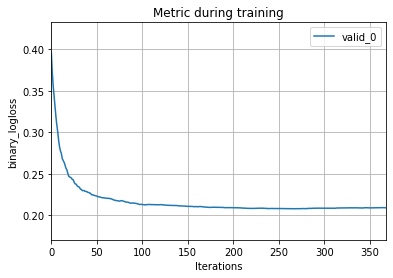

In [15]:
lgbmclf = lightgbm.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, 
                                  n_estimators=500)
lgbmclf.fit(X_train, y_train, 
            eval_set=(X_test,y_test), eval_metric='f1_micro', verbose=False, early_stopping_rounds=100)
lightgbm.plot_metric(lgbmclf);

In [16]:
print(lgbmclf.best_iteration_)

268


In [17]:
lgbmclf = lightgbm.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, n_estimators=268)
lgbmclf.fit(X_train, y_train, verbose=False)

LGBMClassifier(n_estimators=268, random_state=0)

In [18]:
y_pred = lgbmclf.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.9299670134483634